# Twitter-XLM-roBERTa-base for Sentiment Analysis
# Entity detection and Topic extraction
This is a multilingual XLM-roBERTa-base model trained on ~198M tweets and finetuned for sentiment analysis. The sentiment fine-tuning was done on 8 languages (Ar, En, Fr, De, Hi, It, Sp, Pt) but it can be used for more languages (see paper for details).

https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

Ref: @InProceedings{barbieri-espinosaanke-camachocollados:2022:LREC,
  author    = {Barbieri, Francesco  and  Espinosa Anke, Luis  and  Camacho-Collados, Jose},
  title     = {XLM-T: Multilingual Language Models in Twitter for Sentiment Analysis and Beyond},
  booktitle      = {Proceedings of the Language Resources and Evaluation Conference},
  month          = {June},
  year           = {2022},
  address        = {Marseille, France},
  publisher      = {European Language Resources Association},
  pages     = {258--266},
  abstract  = {Language models are ubiquitous in current NLP, and their multilingual capacity has recently attracted considerable attention. However, current analyses have almost exclusively focused on (multilingual variants of) standard benchmarks, and have relied on clean pre-training and task-specific corpora as multilingual signals. In this paper, we introduce XLM-T, a model to train and evaluate multilingual language models in Twitter. In this paper we provide: (1) a new strong multilingual baseline consisting of an XLM-R (Conneau et al. 2020) model pre-trained on millions of tweets in over thirty languages, alongside starter code to subsequently fine-tune on a target task; and (2) a set of unified sentiment analysis Twitter datasets in eight different languages and a XLM-T model trained on this dataset.},
  url       = {https://aclanthology.org/2022.lrec-1.27}
}


## 1. Instalamos Paquetes requeridos

In [ ]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install transformers
!python -m spacy download es_core_news_lg


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


## 2. Importamos módulos requeridos

In [144]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification, pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

import numpy as np
import pandas as pd
import spacy
from scipy.special import softmax
from transformers import pipeline
from scipy.spatial.distance import cosine
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

import urllib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import nltk
import re 
import string
from numpy import argmax
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
# essential entity models downloads
nltk.downloader.download('maxent_ne_chunker')
nltk.downloader.download('words')
nltk.downloader.download('treebank')
nltk.downloader.download('maxent_treebank_pos_tagger')
nltk.downloader.download('punkt')
nltk.download('averaged_perceptron_tagger')
nlp = spacy.load("es_core_news_lg")
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Cargamos datos de ejemplo

In [ ]:
# Cargamos el archivo CSV previamente unificado con likes y comments
from google.colab import drive
drive.mount('/content/drive')

In [95]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SISTEMA REPUTACION ONLINE/bnpl.csv', low_memory=False) # For .csv files low_memory=False
#df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SISTEMA REPUTACION ONLINE/bnpl_excel.xlsx')

In [96]:
# Limpiar dataset
df.dropna(axis=0, inplace=True)
df.reset_index()
df.drop_duplicates(inplace = True)

### Creamos dos nuevas columnas para almacenar longitud  y cantidad de palabras de cada noticia o tweet.

In [97]:
#Calculating tweet’s lenght and word count
df['text_len'] = df['CONTENIDO'].astype(str).apply(len)
df['text_word_count'] = df['CONTENIDO'].apply(lambda x: len(str(x).split()))

In [98]:
df.head()

,URL,TITULO,CONTENIDO,FECHA DE PUBLICACION,text_len,text_word_count
0,https://americasmi.com/insights/bnpl-buy-now-p...,EL MODELO “BUY NOW PAY LATER” Y SU POTENCIAL D...,El modelo Buy Now Pay Later (BNPL) que se trad...,30/03/2022,3152,522
1,https://www.valoraanalitik.com/2022/08/18/tarj...,"Entrevista | Tarjeta virtual ‘buy now, pay lat...",En medio de un contexto en el que los consumid...,18/08/2022,12035,1908
2,https://www.linkedin.com/pulse/compra-ahora-pa...,"Compra ahora, Paga Después","Para la mayoría de latinoamericanos, especialm...",21/02/2022,7034,1115
3,https://www.sectorial.co/articulos-especiales/...,"Compra Ahora y Paga Después, Representará USD ...",El efectivo sigue siendo el método de pago más...,26/07/2022,6185,1037
4,https://vtex.com/es/blog/tendencia-es/bnpl-la-...,BNPL: La revolución del «compra ahora y paga d...,"Cuando las soluciones de «compra ahora, paga d...",17/06/2022,12217,2004


In [99]:
# Definimos la variable list de entrada para todos los modelos (Se extrae de la columna con los tweets o noticias, que espera se llame 'CONTENIDO')
text = df['CONTENIDO'].values.astype(str)

In [48]:
# Llevamos el texto de entrada al formato String
text = str(text)

## 3. Función para limpiar el texto de entrada

In [28]:
# Creamos la funcion 'transform_text' que va a remover stopwords y algunos caracteres peculiares de twitter

# Definimos la lista de palabras Stop en español


stoplist = set(stopwords.words('spanish'))

def transform_text(text):
  text = str(text)
  text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #Remover menciones @
  text = re.sub(r'RT[|\s]', ' ', text) # Remover RTs
  text = re.sub(r'#', ' ', text) #Remover # en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
  text = text.lstrip(' ') # Remover espacios delante del texto

  pattern = r'''(?x)                    # set flag to allow verbose regexps
              (?:[A-Z]\.)+            # abbreviations, e.g. U.S.A
              | \w+(?:-\w+)*          # Words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?    # Currency and precentages, e.g. $12.40 82%
              | \.\.\.                # Ellipsis
              | [][.,;"'?():-_`]      #These are separate tokens; includes ],[
              '''
  words = nltk.regexp_tokenize(text, pattern)
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # Remover signos de puntuacion
  stripped = [re_punc.sub('', w) for w in words]
  no_garbage = [w for w in stripped if  w.lower() not in stoplist] # Remover stopwords

  return (" ".join(no_garbage))

In [49]:
# Limpiamos el texto de entrada
text = transform_text(text)

## 4. Función para extraer entidades (Lugares, Personalidades, Organizaciones, misceláneos)

In [51]:
def entidades(text):
  """ 
  Función que toma un texto (String), tweet o noticia, como entrada y devuelve 
  las siguientes cuatro listas: 
  1. Organizaciones (unique_orgs) 
  2. Localidades (unique_places)
  3. Personalidades (unique_persons)
  4. Misceláneos (unique_misc)
  """
  # Cargamos el modelo
  doc = nlp(text)

  # Creamos las listas donde se guardarán los resultados
  orgs = []
  places = []
  persons = []
  misc = []

  for ent in doc.ents:
    org = [(e.text) for e in doc.ents if e.label_ == 'ORG']
    orgs.append(org)
    lugar = [(e.text) for e in doc.ents if e.label_ == 'LOC']
    places.append(lugar)
    pers = [(e.text) for e in doc.ents if e.label_ == 'PER']
    persons.append(pers)
    miscel = [(e.text) for e in doc.ents if e.label_ == 'MISC']
    misc.append(miscel)

  x = np.array(orgs)
  unique_orgs = np.unique(x)
  y = np.array(places)
  unique_places = np.unique(y)
  z= np.array(persons)
  unique_persons = np.unique(z)
  w= np.array(misc)
  unique_misc = np.unique(w)
  
  # Habilitar sólo si queremos enviar salida por consola (print)
  counter = 1
  #print("Los organismos encontrados son: \n")
  for item in unique_orgs:
      #print(str(counter) + '- ' + f'{item}')
      counter+=1

  counter = 1
  #print("\n")
  #print("Los lugares encontrados son: \n")
  for place in unique_places:
      #print(str(counter) + '- ' + f'{place}')
      counter+=1

  counter = 1
  #print("\n")
  #print("Las Personalidades encontradas son: \n")
  for p in unique_persons:
      #print(str(counter) + '- ' + f'{p}')
      counter+=1
  #print("\n")
  # ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
  return unique_orgs, unique_places, unique_persons, unique_misc

  #print("Las entidades encontradas son: \n", ent.text+' -- '+ent.label_+' -- '\
           #+spacy.explain(ent.label_))
  

In [52]:
#for item in range(len(df)):
unique_orgs, unique_places, unique_persons, unique_misc = entidades(text)

## 4. Función para el reconocimiento de tópicos

In [181]:
def topicos(text, labels):
  """
  Función que recibe el texto y una lista con los tópicos de referencia
  Devuelve el % de cada tópico presente en el texto
  """
  result = classifier(text, 
                      candidate_labels=labels,
                      hypothesis_template= "Este ejemplo es sobre {}.")
  return result


In [57]:
# Función para detectar tópicos en el texto
# Cargamos el modelo
classifier = pipeline("zero-shot-classification", 
                       model="Recognai/bert-base-spanish-wwm-cased-xnli")

candidate_labels = ['cultura', 'sociedad', 'economia', 'salud', 'deportes', \
                    'politica', 'tecnologia', 'negocios', 'ecologia']

def topic_detect(df):
  """
  Función para detectar los tópicos presentes en un texto y clasificarlo de acuerdo
  a la influencia de estos.
  Esta función espera como entrada un dataframe con una columna llamada 'CONTENIDO'
  """
  candidate_results = [0]*len(candidate_labels) # Lista para guardar resultados

  for sent in df['CONTENIDO'].values:
    # To do multi-class classification, simply pass multi_class=True.
    # In this case, the scores will be independent, but each will fall between 0 and 1.
    res = classifier(sent, candidate_labels)

    SCORES = res["scores"]
    CLASSES = res["labels"]
    BEST_INDEX = argmax(SCORES)
    predicted_class = CLASSES[BEST_INDEX]
    predicted_score = SCORES[BEST_INDEX]
    #print(predicted_class)
    #print(predicted_score)

  # Adecuar para que coincida con las etiquetas qeu se definan arriba en "candidate_labels"
    if predicted_class == 'cultura':
        candidate_results[0] = candidate_results[0] + 1
    if predicted_class == 'sociedad':
        candidate_results[1] = candidate_results[1] + 1
    if predicted_class == 'economia':
        candidate_results[2] = candidate_results[2] + 1
    if predicted_class == 'salud':
        candidate_results[3] = candidate_results[3] + 1
    if predicted_class == 'deportes':
        candidate_results[4] = candidate_results[4] + 1
    if predicted_class == 'politica':
        candidate_results[5] = candidate_results[5] + 1
    if predicted_class == 'tecnologia':
        candidate_results[6] = candidate_results[6] + 1
    if predicted_class == 'negocios':
        candidate_results[7] = candidate_results[7] + 1
    if predicted_class == 'ecologia':
        candidate_results[8] = candidate_results[8] + 1
  return candidate_results


In [61]:
candidate_results = topic_detect(df)

In [62]:
print(candidate_results) # Sólo para visualizar cuando presentemos. No va en Back

[0, 0, 2, 0, 0, 6, 6, 11, 0]


In [63]:
# Sólo para visualizar cuando presentemos. No va en Back
data = {'labels': candidate_labels,
        'values': candidate_results}

df_chart = pd.DataFrame(data, columns=['labels','values'])

df_chart.head(10)

,labels,values
0,cultura,0
1,sociedad,0
2,economia,2
3,salud,0
4,deportes,0
5,politica,6
6,tecnologia,6
7,negocios,11
8,ecologia,0


Plotting most frequent topics (Sólo para visualizar. No va en Back)

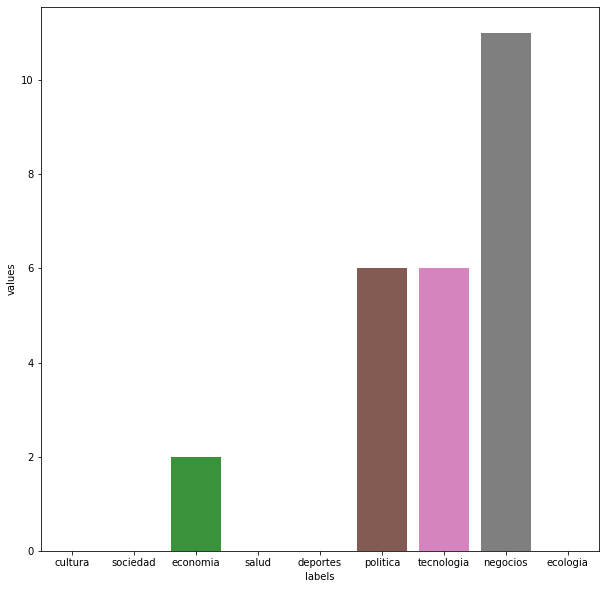

In [64]:
# Sólo para visualizar cuando presentemos. No va en Back
ax = sns.barplot(data = df_chart
            ,x = 'labels'
            ,y = 'values'
            )
ax.figure.set_size_inches(10,10)

## 5. Análisis de Sentimientos

In [165]:
# Definimos configuración del Modelo
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


[{'label': 'Positive', 'score': 0.6600582599639893}]

### Guardar el modelo (Como respaldo)

In [72]:
# Save the model
#model.save_pretrained(MODEL)

### Función Análisis de Sentimientos

In [173]:
# Function to predict Sentiment
def sentiment_task(text):
  """Función para analizar el sentimiento en un texto.
  Espera una entrada tipo "string" y como Salida genera una lista con dos valores:
  1. La etiqueta del sentimiento
  2. La intensidad del sentimiento"""
  #text = transform_text(text)
  encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  # Print labels and scores
  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  
  for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    #print(f"{i+1}) {l} {np.round(float(s), 4)}")

  pred = config.id2label[ranking[0]]
  intensidad = np.round(float(scores[ranking[0]]), 4)*100
  results = [pred, intensidad]
  return results

### Función predecir tipo de Sentimiento en un tweet o noticia

In [106]:
# Function to emsembler the resulting DataFrame
def data_predicts(df):
  """
  Función para predecir el tipo de sentimiento en un texto (Max 512 caracteres).
  Espera una entrada en lotes o batchs tipo "string" (columna 'CONTENIDO' en un dataframe)
  y como Salida genera un dataframe con cinco columnas:
  1. Texto de la noticia o tweet
  2. Longitud del texto en palabras
  3. Cantidad de palabras en el texto
  4. La etiqueta del sentimiento (Positivo, Neutral o Negativo)
  5. La intensidad del sentimiento
  """

  results_pred = []
  results_inten = []
  #configs = []
  texto = []
  try:
    for i in range(0, len(df)):
      long_text = df['text_len'].to_list()
      num_words = df['text_word_count'].to_list()
      text = df['CONTENIDO'][i][:512]
      text = str(text)
      pred = sentiment_task(text)
      results_pred.append(pred[0]) # For sentiment_task func
      #results_pred.append(pred[0]['label']) # For pipeline
      #configs.append(configur)
      results_inten.append(pred[1]) # For sentiment_task func
      #results_inten.append(pred[0]['score']) # For pipeline
      texto.append(text)
  except KeyError:
    pass
  data = {'text': texto,
          'longitud_texto': long_text,
          'cantidad_palabras': num_words,  
        'sentimiento': results_pred,
        'intensidad':results_inten
        }
  resultados = pd.DataFrame(data)
  return resultados
  #print(dataset[tweet], '--->', config.id2label[pred])
  #preds = np.argmax(scores, axis=-1)


In [107]:
data_predicts = data_predicts(df)

In [108]:
data_predicts.head()

,text,longitud_texto,cantidad_palabras,sentimiento,intensidad
0,El modelo Buy Now Pay Later (BNPL) que se trad...,3152,522,Neutral,71.52
1,En medio de un contexto en el que los consumid...,12035,1908,Neutral,74.05
2,"Para la mayoría de latinoamericanos, especialm...",7034,1115,Negative,52.05
3,El efectivo sigue siendo el método de pago más...,6185,1037,Neutral,79.91
4,"Cuando las soluciones de «compra ahora, paga d...",12217,2004,Neutral,43.93


### Función para "tokenizar"

In [85]:
# tokenize helper function
import string
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    #stoplist = set(stopwords.words('spanish'))
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stoplist]

### Extraemos todas las palabras asociadas a sentimiento "Positivo"

In [90]:
# Almacenamos las palabras asociadas a sentimiento positivo
all_pos_words = []
df_pos = data_predicts[data_predicts.sentimiento=="Positive"]
df_pos['tokens'] = df_pos['text'].apply(text_process) # tokenize

for line in df_pos['tokens']: # try 'tokens'
    all_pos_words.extend(line)


### Extraemos todas las palabras asociadas a sentimiento "Negativo"

In [92]:
# Todas las palabras asociadas a sentimientos Negativos

all_neg_words = []
df_neg =data_predicts[data_predicts.sentimiento=="Negative"]
df_neg['tokens'] =df_neg['text'].apply(text_process) # tokenize

for line in df_neg['tokens']: # try 'tokens'
    all_neg_words.extend(line)

### Calculamos la longitud y cantidad de palabras promedio por noticia o tweet

In [109]:
text_len_mean = round(pd.DataFrame(data_predicts.groupby('sentimiento').longitud_texto.mean()),2)
text_len_mean

,longitud_texto
sentimiento,
Negative,7034.00
Neutral,5312.54


In [111]:
word_count_mean = round(pd.DataFrame(data_predicts.groupby('sentimiento').cantidad_palabras.mean()),2)
word_count_mean

,cantidad_palabras
sentimiento,
Negative,1115.00
Neutral,857.71


### Función para calcular frecuencia de palabras

In [ ]:
def freq_palabras(lista):
  wordfreq = Counter(lista)
  return wordfreq

Seleccionamos sólo las palabras con frecuencia mayor a 3 veces

In [131]:
# create a word frequency dictionary for positive and negatives words 
wordfreq_pos = freq_palabras(all_pos_words)
wordfreq_neg = freq_palabras(all_neg_words)

In [132]:
etiqs = [k for (k,v) in wordfreq_pos.items() if v > 3]

In [133]:
vals = [v for (k,v) in wordfreq_pos.items() if v > 3]

In [129]:
if etiqs !=[]:
  # Let's get a Bar chart
  keys = etiqs

  # get values in the same order as keys, and parse percentage values
  values = sorted(vals, reverse=True)

  sns.barplot(x=keys, y=values)

### Función para contar palabras en una columna y obtener el %

In [182]:
# Let’s count values for sentiment features and see total — percentage.

#Function for count_values_in single columns
def count_values_in_column(data,feature): 
  total=data.loc[:,feature].value_counts(dropna=False)
  percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
  return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])


### Plotting Pie chart  (Los gráficos que van en el Back debe definirlos Amílcar)

In [183]:
# create data for Pie Chart
def plot_pie(df, column):
  pc = count_values_in_column(df,column)
  names= pc.index
  size=pc['Percentage']
  colors=['red','blue','green']
  colours = {'Negative': colors[0], 'Neutral': colors[1], 'Positive': colors[2]} 
  #labels = ['NEGATIVO', 'NEUTRAL', 'POSITIVO'] 

  # Create a circle for the center of the plot
  my_circle=plt.Circle( (0,0), 0.5, color='white')
  plt.pie(size, labels=names, colors=[colours[key] for key in names], autopct='%1.0f%%            ')
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

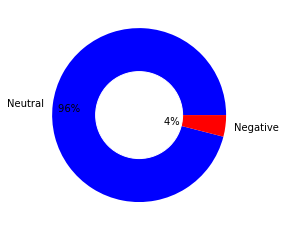

In [184]:
plot_pie(data_predicts,'sentimiento')

## 6. Análisis de Sentimientos de Bigram/Trigram (***Función que usaremos***)
Let's explore some word associations. N-grams analyses are often used to see which words often show up together.

In [150]:
def bigram(df):
  #stoplist = set(stopwords.words('spanish'))
  c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
  # matrix of ngrams
  ngrams = c_vec.fit_transform(df['CONTENIDO'])
  # count frequency of ngrams
  count_values = ngrams.toarray().sum(axis=0)
  # list of ngrams
  vocab = c_vec.vocabulary_
  df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
  return df_ngram

In [147]:
df_ngram = bigram(df)

#### Definimos el tipo de Sentimiento y la intensidad del bigram/trigram.

In [174]:
df_ngram['polarity_intensity'] = df_ngram['bigram/trigram'].apply(sentiment_task)


In [176]:
df_ngram['polaridad'] = df_ngram['polarity_intensity'].apply(lambda x: x[0])
df_ngram['intensidad'] = df_ngram['polarity_intensity'].apply(lambda x: x[1])

### Gráfico de anillo (Sólo para demostración, no va en Back)

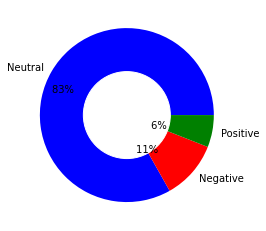

In [180]:
plot_pie(df_ngram, 'polaridad')